# 0. 기본 정보
- 코드 작성자: 여서연
- 코드 작성일: 2024-11-04
- 코드 작성 목적: 시계열 데이터 딥러닝 백테스팅 구현 실습

# 1. 기초 설정

## 사용 라이브러리

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 백테스팅
import yfinance as yf
import backtrader as bt

In [3]:
# 딥러닝
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

In [4]:
# 파라미터 최적화
from functools import partial
import pandas as pd

## 기타 설정

In [5]:
# 소수점 아래 2자리까지 표시
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [6]:
# 한국어 및 한국 지역 형식 설정
import locale

locale.setlocale(locale.LC_ALL, 'ko_KR')

'ko_KR'

In [7]:
# 모든 경고 무시
import warnings

warnings.filterwarnings('ignore')

# 2. 데이터 다운로드 및 전처리

## 2-1. 다운로드

In [8]:
data = yf.download('TQQQ', period='2y', interval='1h')
# ['1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max']")

[*********************100%***********************]  1 of 1 completed


In [9]:
print(data.shape)

(3505, 6)


<Axes: xlabel='Datetime'>

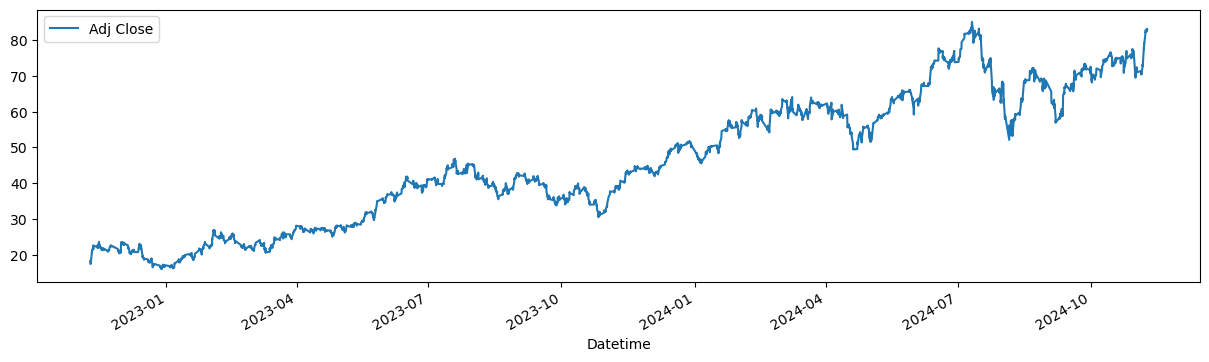

In [10]:
data['Adj Close'].plot(figsize=(15,4), legend=True)

## 2-2. 전처리

In [11]:
# 훈련용 테스트용 분리
from sklearn.model_selection import train_test_split
train, test = train_test_split(data['Adj Close'].values, random_state=66, test_size=0.2, shuffle=False)

print('train의 구조:', train.shape)
print('test의 구조:', test.shape)

train의 구조: (2804,)
test의 구조: (701,)


In [12]:
# 수정 종가(Adj Close)만 사용하여 LSTM 모델 학습에 사용할 데이터 준비
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))
train_scaled = sc.fit_transform(train.reshape(-1,1))

In [13]:
train_scaled

array([[0.03690291],
       [0.03608922],
       [0.03395894],
       ...,
       [0.98876929],
       [0.98543309],
       [0.9806339 ]])

In [14]:
# 데이터셋을 시퀀스로 나누기
# time step 단위 = interval 단위
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(1, len(data)):
        X.append(data[i - time_step:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

In [15]:
time_step = 1  # 1시간씩 묶은 데이터를 기반으로 예측
X_train, y_train = create_dataset(train_scaled, time_step)

In [16]:
X_train.shape

(2803, 1)

In [17]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(2803, 1, 1)

In [18]:
# 훈련 데이터를 기준으로 검증 데이터를 동일한 스케일로 변환
inputs = sc.transform(test.reshape(-1,1))
inputs.shape

(701, 1)

In [19]:
time_step = 1  # 1시간씩 묶은 데이터를 기반으로 예측
X_test, y_test = create_dataset(inputs, time_step)

In [20]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape

(700, 1, 1)

# 3. 모델 구축

## 3-1. LSTM

In [21]:
lstm = Sequential()
lstm.add(LSTM(units=6, input_shape=(X_train.shape[1], 1)))
lstm.add(Dense(units=1, activation='linear'))

In [22]:
print(lstm.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 6)              │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 199 (796.00 B)

 Trainable params: 199 (796.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [23]:
lstm.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mse'])
lstm.fit(X_train, y_train, epochs=2, batch_size=1)

Epoch 1/2
2803/2803 ━━━━━━━━━━━━━━━━━━━━ 3s 837us/step - loss: 0.0500 - mse: 0.0500
Epoch 2/2
2803/2803 ━━━━━━━━━━━━━━━━━━━━ 2s 810us/step - loss: 1.0701e-04 - mse: 1.0701e-04


# 4. 예측

In [24]:
lstm_pred = lstm.predict(X_test)
lstm_pred = sc.inverse_transform(lstm_pred)

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


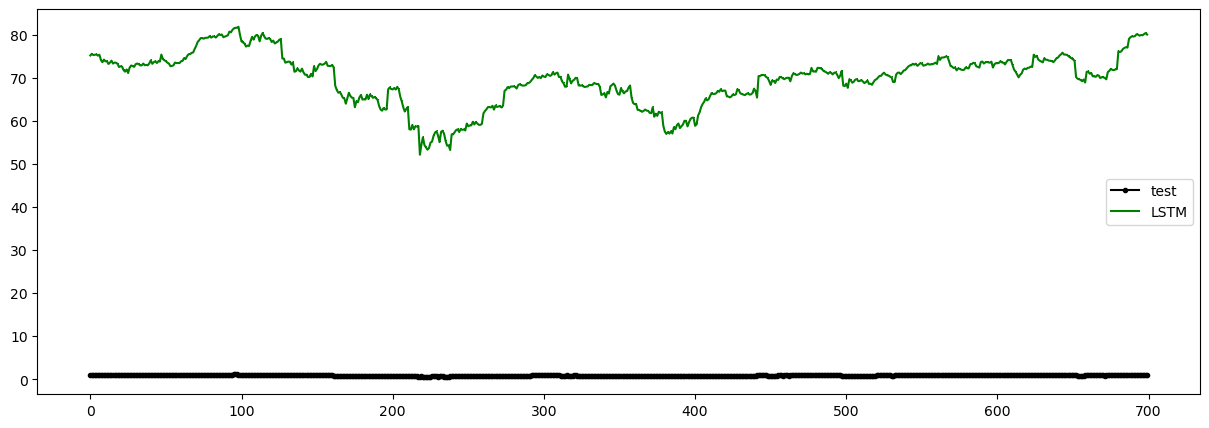

In [25]:
plt.figure(figsize=(15, 5))
plt.plot(y_test, marker='.', label='test', color='black')
plt.plot(lstm_pred, marker=',', label='LSTM', color='green')
plt.legend()
plt.show()

# 5. 전략 정의

# 6. 시뮬레이션

In [26]:
data_feed1 = bt.feeds.PandasData(dataname=data)

In [27]:
'''
cerebro = bt.Cerebro()  # Cerebro 엔진 생성
cerebro.broker.setcash(100_000_000)  # 초기 자본 설정
cerebro.broker.setcommission(0.002)  # 거래 수수료 설정
cerebro.adddata(data_feed1)  # 데이터 추가
cerebro.addstrategy()  # 전략 추가

start_value = cerebro.broker.getvalue()  # 백테스트 시작 시 자산 값 저장
cerebro.run()  # 백테스트 실행
final_value = cerebro.broker.getvalue()  # 백테스트 종료 후 자산 값 저장
'''

'\ncerebro = bt.Cerebro()  # Cerebro 엔진 생성\ncerebro.broker.setcash(100_000_000)  # 초기 자본 설정\ncerebro.broker.setcommission(0.002)  # 거래 수수료 설정\ncerebro.adddata(data_feed1)  # 데이터 추가\ncerebro.addstrategy()  # 전략 추가\n\nstart_value = cerebro.broker.getvalue()  # 백테스트 시작 시 자산 값 저장\ncerebro.run()  # 백테스트 실행\nfinal_value = cerebro.broker.getvalue()  # 백테스트 종료 후 자산 값 저장\n'

In [28]:
'''
# 자산 변화 출력
print('* start value : %s $' % locale.format_string('%d', start_value, grouping=True))
print('* final value : %s $' % locale.format_string('%d', final_value, grouping=True))
print('* earning rate : %.2f %%' % ((final_value - start_value) / start_value * 100.0))
'''

"\n# 자산 변화 출력\nprint('* start value : %s $' % locale.format_string('%d', start_value, grouping=True))\nprint('* final value : %s $' % locale.format_string('%d', final_value, grouping=True))\nprint('* earning rate : %.2f %%' % ((final_value - start_value) / start_value * 100.0))\n"

In [29]:
'''
# 백테스트 결과 차트 출력
cerebro.plot(iplot=False)
'''

'\n# 백테스트 결과 차트 출력\ncerebro.plot(iplot=False)\n'

# 7. 파라미터 비교

## 함수 설정

## 기존 데이터 사용

In [30]:
# 시뮬레이션 수행


In [31]:
# 결과 데이터프레임 생성


## 다른 데이터 사용

In [32]:
data2 = bt.feeds.PandasData(dataname=yf.download("SQQQ", period='5d', interval='1m'))

[*********************100%***********************]  1 of 1 completed
